**<span style="color:#0638b2; font-size:32px">
Phase II - Model Fine Tuning and Saving
</span>** <br>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile

In [6]:
os.getcwd()

'/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project'

**<span style="color:#180842; font-size:26px">
Train/Validation Data
</span>** <br>

In [7]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"

In [8]:
data_dir = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6974


In [10]:
# Drill into each subdirectory and list counts per folder
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3034 .jpg images

Contents of folder 'non_landslide':
non_landslide: 3940 .jpg images


**<span style="color:#180842; font-size:26px">
Test Data
</span>** <br>

In [11]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

In [12]:
data_dir_test = tf.keras.utils.get_file('test_google_images_landslide_three.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [13]:
## Review folders in incoming data / classes
folders_test = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders_test:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images


In [14]:
# Drill into each subdirectory and list files
for folder in folders_test:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 47 .jpg images
  Subfolder: non-landslides
non-landslides: 67 .jpg images
  File: .DS_Store


**<span style="color:#180842; font-size:26px">
Set Training/Validation Data & Split
</span>** <br>

In [15]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [16]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="training",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 5580 files for training.


2024-11-29 13:08:42.466981: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46853 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [17]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="validation",
  seed=634,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 1394 files for validation.


In [18]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset.unbatch())
valid_count = sum(1 for _ in valid_dataset.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset, train_class_counts)
count_classes(valid_dataset, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-11-29 13:08:53.422435: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-29 13:08:54.706925: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 5580
Validation set size: 1394

Class distribution in Training set:
  Class 0: 2445 samples
  Class 1: 3135 samples

Class distribution in Validation set:
  Class 0: 589 samples
  Class 1: 805 samples


2024-11-29 13:09:00.881440: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Buffering/Shuffle

In [19]:
## Data Performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(3200).prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(buffer_size=AUTOTUNE)

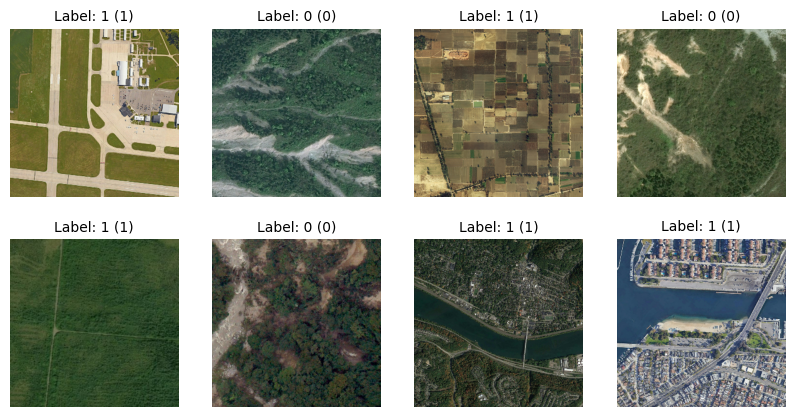

In [20]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

**<span style="color:#180842; font-size:26px">
Set Test Data
</span>** <br>

In [21]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) / 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images')

In [22]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 114 files belonging to 2 classes.


In [23]:
## Review class names based on dataset. 
class_names = test_dataset.class_names
print(class_names)

['landslides', 'non-landslides']


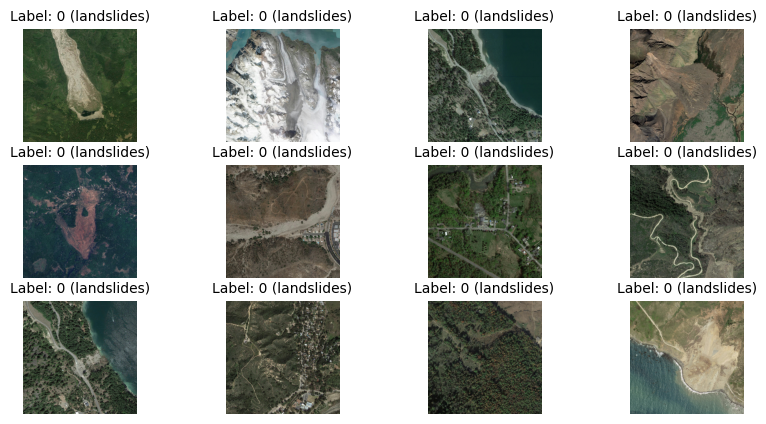

In [24]:
## Checking the Labels. 
plt.figure(figsize=(10, 5))
for images, labels in test_dataset.take(1):  # Take one batch
    for i in range(12):  # Display first 6 samples
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #301b66">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [25]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.1411042944785277, 1: 0.8899521531100478}


<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Model Design w/ Transfer Learning
</span>** <br>


Pre-Training with EfficientNet
- Strengths: EfficientNet models scale well in terms of parameters and efficiency, balancing accuracy with computational cost, which is especially useful for large datasets.
- Suitability: EfficientNet performs exceptionally well on high-resolution images, which is ideal for detecting fine details in satellite images.
- https://viso.ai/deep-learning/efficientnet/
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

**Setting up EfficientNet**
- Note - using B3 as this is set up for 300x300 images. 

In [26]:
## Import EFB3 Model Weights
from tensorflow.keras.applications import EfficientNetB3

In [27]:
## Calc. the number of classes. 
land_class_num = len(folders)
land_class_num

2

In [28]:
# Setting up parameters for model. 
IMG_SIZE=300
learn_rate_land = .0001  ## For optimizer.

print(land_class_num) ## Check class number AND use as argument below.

2


### **Helper Functions**

In [29]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Saturation
- The saturation factor is sampled randomly from a uniform distribution in the range [lower, upper].
- A saturation factor of 1.0 means no change in saturation.
- A saturation factor below 1.0 decreases the saturation (the image will appear less vibrant or more grayscale).
- A saturation factor above 1.0 increases the saturation (the image will appear more vibrant).

In [32]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomRotation(factor=0.10),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomContrast(factor=0.5),
    keras.layers.RandomBrightness(factor=.6),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
  ]
)

## **Model**

In [33]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


## **Fit**

In [35]:
## Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

epochs = 4  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)


Epoch 1/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 197ms/step - accuracy: 0.7036 - loss: 0.6314 - val_accuracy: 0.8881 - val_loss: 0.2882
Epoch 2/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.8991 - loss: 0.2390 - val_accuracy: 0.9268 - val_loss: 0.1875
Epoch 3/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9311 - loss: 0.1679 - val_accuracy: 0.9419 - val_loss: 0.1476
Epoch 4/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9512 - loss: 0.1279 - val_accuracy: 0.9498 - val_loss: 0.1216


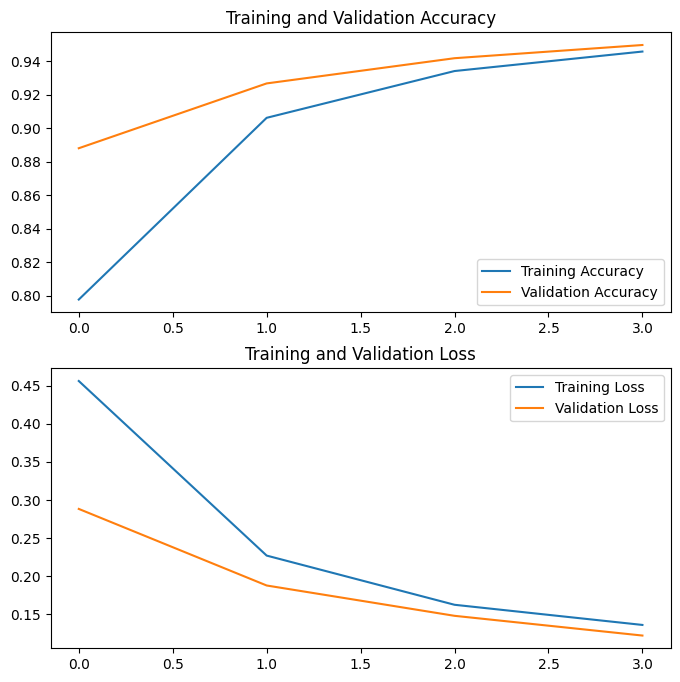

In [36]:
## Plot results
visualize_model_results(landslide_ENB3_hist)

## **Testing**

In [37]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5796 - loss: 0.8960
test loss, test acc: [0.8185871243476868, 0.6052631735801697]


In [38]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step


2024-11-29 13:21:15.461628: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


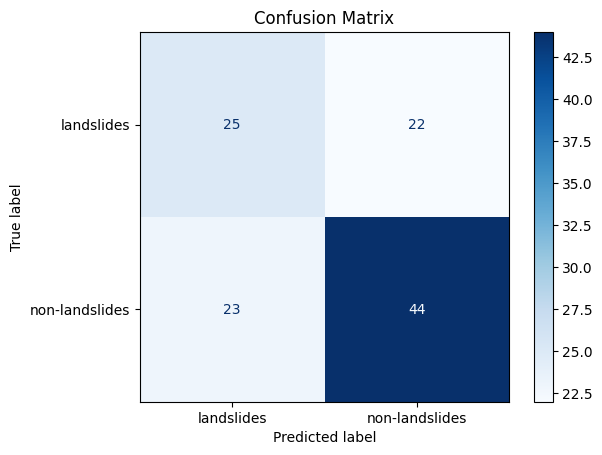

In [39]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Identify Image File to Prediction|True Labels

In [41]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Images with predicted and true labels:
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_10521_large.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_13710_cat.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_14445_cat.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/nasa_g_1950m_14143_2018_vylg.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/nasa_g_2000m_10521_2017_large_two.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extr

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Fine Tuning - Opening Up Feature Layers
</span>** <br>

In [42]:
## Number of Layers to Open!!!
layer_open = 15
layer_open

15

In [44]:
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

## **Fit Model** 

In [45]:
unfreeze_model(landslide_model_ENB3, layer_open)

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 4  # @param {type: "slider", min:8, max:80}
ENB3_hist_fine = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)


Epoch 1/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 73s 218ms/step - accuracy: 0.9460 - loss: 0.1319 - val_accuracy: 0.9570 - val_loss: 0.0971
Epoch 2/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9549 - loss: 0.1126 - val_accuracy: 0.9656 - val_loss: 0.0824
Epoch 3/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9697 - loss: 0.0817 - val_accuracy: 0.9713 - val_loss: 0.0680
Epoch 4/4
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9785 - loss: 0.0633 - val_accuracy: 0.9756 - val_loss: 0.0585


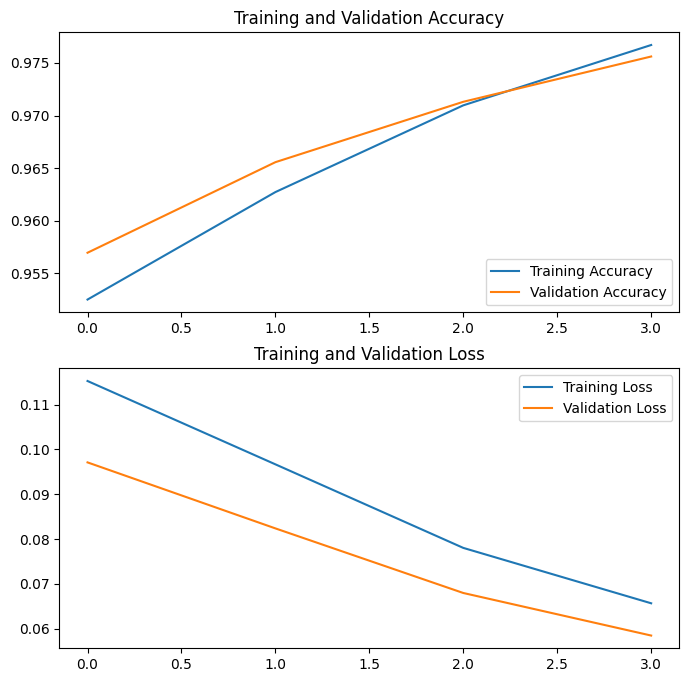

In [46]:
## Plot results
visualize_model_results(ENB3_hist_fine)

## **Testing**

In [47]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6107 - loss: 1.0381
test loss, test acc: [0.8861877918243408, 0.6491228342056274]


In [48]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step


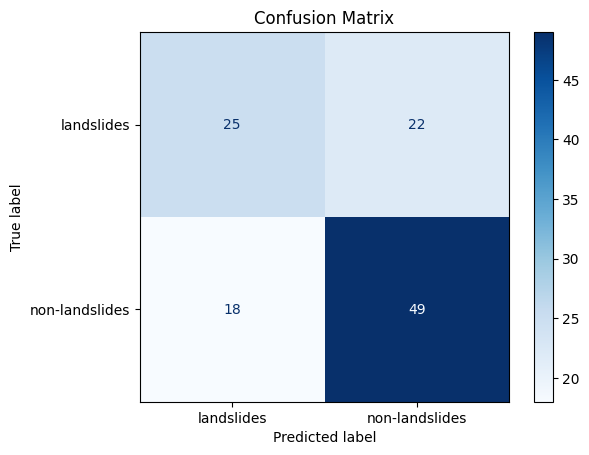

In [49]:
## Confusion Matrix
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Identify Image File to Prediction|True Labels

In [50]:
file_paths = test_dataset.file_paths  # This retrieves file paths corresponding to each sample

# Get predictions
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class

# Extract true labels
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Map file paths to predictions
file_class_map = zip(file_paths, y_pred, y_true)  # Zip paths, predictions, and true labels

print("\nImages with predicted and true labels:")
for file_path, pred, true in file_class_map:
    if pred != true & true == 0:    ## Added to only see where prediction is INCORRECT...
        print(f"File: {file_path}, Predicted: {pred}, True Label: {true}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Images with predicted and true labels:
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_10521_large.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_13710_cat.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/NASA_GoogE_14445_cat.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/nasa_g_2000m_10521_2017_large_two.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_extracted/Google_Earth_Images/landslides/nasa_g_2000m_14329_2011_large.jpg, Predicted: 1, True Label: 0
File: /home/waa4bq/.keras/datasets/test_google_images_landslide_three_ext

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Train Model on Full Population
</span>** <br>

<hr style="border:8px solid #301b66">

**<span style="color:#0638b2; font-size:30px">
Saving Model for Future Use
</span>** <br>

In [52]:
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
# model.save("my_model.keras")
landslide_model_ENB3.save("/sfs/gpfs/tardis/home/waa4bq/Documents/MSDS/6050 Deep Learning/DS6050_Project/ENB3_One_hh.keras")